# CMSC478 Machine Learning - Spring 2022

# Instructor: Fereydoon Vafaei

### Assignment-3: Multi-Class Classification, PCA, and Image Segmentation Using Clustering

Jacob Enoch YU11019

## Overview and Learning Objectives

In Assignment-3, you're going to first perform a multi-class classification task. Then, you'll practice with PCA. Finally, you will apply K-Means and GMM (EM algorithm) for image segmentation.

As discussed in the lectures, multi-class classification means your model classifies multiple (more than two) classes/labels. You are going to build a classifier that can predict orthopedic disease (three classes).

<b>Course Policy Reminder:</b>
Debugging and error resolution are always students' responsbility. This policy will be enforced in email communications and the office hours. Keep in mind that all assignments are individual graded tasks. Any collaboration with other students is strictly prohibited and is considered as cheating. Students should NOT share any answer, solution, or code with other students. Violations of these policies would be penalized according to UMBC academic integrity policy.

**You must run ALL cells** and get the correct outputs for all cells and give complete answers to all questions. **Cells/codes with no output get zero!**

Pedagogically, this assignment will help you:
- better understand multi-classification and the challenge of imbalanced datasets
- better understand and practice with PCA
- learn how to apply clustering algorithms for image segmentation

## Import Cell

The first step is importing all necessary python and sklearn modules. **You definitely need to add to the following imports as you work on the assignment.** When you import a new module, add it here in the same cell. All imports should be in this cell.

In [109]:
# Import all the necessary modules from python and sklearn
# You may start with pandas, numpy and matplotlib,
# and keep adding the necessary modules here as you move forward

# -----General ML imports----- #
import matplotlib.pyplot as plt, pandas as pd, numpy as np, scipy, sklearn
import seaborn as sns # Used for stylized graphing

# ----- Imported Models from SKLearn -----#
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier model
from sklearn.decomposition import PCA  # PCA for dimensionality reduction (6D to 3D)

# ----- SKLearn performance metrics and hyperparameter tuning -----#
from sklearn.model_selection import train_test_split # Used for making a train/test set
from sklearn.model_selection import cross_val_score  # Cross valiation via SKLearn
from sklearn.model_selection import RandomizedSearchCV  # Random Search via cross validation
from sklearn.metrics import balanced_accuracy_score as bac  # Balanced accuracy for classifiers
from sklearn.metrics import classification_report as cr  # Used to analyze classification performance


## Part-I Multi-Class Classification with Imbalanced Dataset

You are going to work with "**the biomechanical features of orthopedic patients**" dataset. You can download the data and read the descriptions in the [kaggle page](https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients).

- There are two versions of this dataset. Make sure to download `column_3C_weka.csv` which has three classes.

- The ML task is classifying patients as belonging to one out of three categories in `class` column: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients). 

Follow the instructions for each step very carefully.

### Preprocessing

In [110]:
# Load the column_3C_weka.csv data as a dataframe using pandas
df = pd.read_csv("column_3C_weka.csv", sep = ",")
df.head(5)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


> This data is very clean; thus the preprocessing is minimal; however, you should always check if there is any NAs.

In [111]:
# Check if there is any NAs
df.isna().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

> Your target column for classification is `class`.

In [112]:
# Get feature vector X (all columns but "class") and target label y as "class"
X = df.drop('class', axis=1)
y = df['class']

In [113]:
# Print X shape and head
print(X.shape)
X.head(5)

(310, 6)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


In [114]:
# Print y shape, head, unique values and number of instances in each class
unique_classes = y.unique()

            
print(y.shape)
print(unique_classes)
print(y.value_counts())
print(y.head(5))

(310,)
['Hernia' 'Spondylolisthesis' 'Normal']
Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64
0    Hernia
1    Hernia
2    Hernia
3    Hernia
4    Hernia
Name: class, dtype: object


> This indicates that the dataset is imbalanced meaning the number of instances in each class is not balanced, so you should be careful with model evaluation as working with imbalanced data requires specific performance metrics that can address the issue of unequal distribution of labels.

> <b>Note:</b> The output of the following cell is provided to you for your reference. All the following cells depend on the correctness of your preprocessing steps and should be verified by this output.

In [115]:
# Split the data to train and test with ratio of 70/30 for train/test respectively
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42) #Random seed makes sure sets stay same each run
 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(217, 6)
(217,)
(93, 6)
(93,)


### Multi-Class Classification

Next, you're going to build a classifier. Some classifiers like [Random Forests in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) can directly be applied on multi-class classification and there is no need to use OvO and OvR strategies, so let's try RF for this problem.

You may start with default hyperparameters, but you should definitely fine-tune them as described in the following cell to achieve at least 0.78 for mean cv score. Your cv `scoring` parameter should use `balanced_accuracy` as its metric. Also notice that - as discussed in the lectures - you must apply `cross_val_score` on the whole dataset (not just train or test). You may see the full documentation of `cross_val_score` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

> **Note**: [The balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) in binary and multiclass classification tasks deals with imbalanced datasets. It is defined as the average of recall obtained on each class, so in this case the average of recall between three classes.

In [116]:
# Create a RandomForestClassifier - You may start with default hyperparameters,
# but you should fine-tune them to achieve at least 0.78 for mean cv score
# Set the random_state=42
rf_clf = RandomForestClassifier()

In [117]:
# This cell is used for hyperparameter tuning to achieve a CV score of 0.78 or lower
# Uses random search CV to find hyperparameters that lower the mean balanced accuracy quickly
np.random.seed(42)

# Uniformly generate hyperparameter values that random search will use 
n_estimators = np.random.uniform(10, 300, 5).astype(int)
criterion = ["gini", "entropy"]
max_depth = np.random.uniform(1, 25, 5).astype(int)
min_samples_split = np.random.uniform(0.1, 0.5, 5)
min_samples_leaf = np.random.uniform(0.1, 0.5, 5)
np.append(max_depth, None)

# Create a dictionary containing hyperparameter values: {'Hyperparameter:' values}
rf_parameters = {
    'n_estimators': n_estimators,
    'criterion': criterion, 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split, 
    'min_samples_leaf': min_samples_leaf
}

# Perform a random search using a 10-fold CV over 10 iterations
random_search = RandomizedSearchCV(rf_clf, rf_parameters, scoring='balanced_accuracy', cv=10, n_iter=10)

# Fit the random search to training set and find best estimator
best_rf_clf = random_search.fit(X_train, y_train)
best_rf = best_rf_clf.best_estimator_
print('Best parameters: ' + str(best_rf_clf.best_params_))

Best parameters: {'n_estimators': 118, 'min_samples_split': 0.4329770563201687, 'min_samples_leaf': 0.17336180394137352, 'max_depth': 17, 'criterion': 'gini'}


In [118]:
# Perform a 10-fold cross validation with scoring='balanced_accuracy'
# Hint: cross validation should be done on the whole dataset

rf_cv_score = cross_val_score(best_rf, X, y, cv = 10, scoring='balanced_accuracy')
print("Mean cv Score - Random Forest: ", rf_cv_score.mean())

Mean cv Score - Random Forest:  0.6044444444444442


> Next, you're going to plot the impact of `n_estimators` hyperparameter on mean cv score. Read the comments in the following cell. cv `scoring` will still be `balanced_accuracy`. 

> **Note**: The following plot is given for your reference. However, notice that due to randomness, there might be slight differences, but the trend should be similar. Running this cell may take a few minutes.

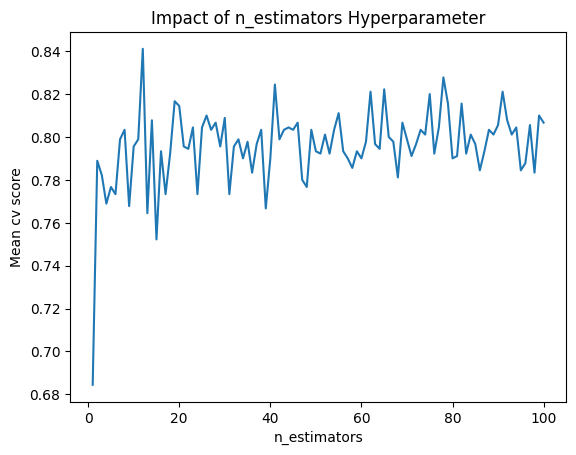

In [119]:
'''Plot the impact of n_estimators hyperparameter on mean cv score as follows:

1- Write a for loop that iterates over n_estimators from 1 to 100
2- In each iteration, do a 10-fold cv with scoring='balanced_accuracy' and calculate rf_cv_score.mean()
and append it to the list rf_mean_cv_scores
3- Finally, plot rf_mean_cv_scores on y-axis versus n_est_list on x-axis
Your plot should have the title "Impact of n_estimators Hyperparameter", and the correct label for each axis
Incomplete/incorrect plots will get zero '''

graphing_rf = RandomForestClassifier()

rf_mean_cv_scores = []
n_est_list = range(1, 101)

for i in n_est_list:
    graphing_rf.set_params(n_estimators=i)
    current_rf_score = cross_val_score(graphing_rf, X, y, cv=10, scoring='balanced_accuracy')
    rf_mean_cv_scores.append(current_rf_score.mean())
    
#---Graphing---#
title = 'Impact of n_estimators Hyperparameter'

x_axis = n_est_list
y_axis = rf_mean_cv_scores

x_label = 'n_estimators'
y_label = 'Mean cv score'

chart = plt.plot(x_axis, y_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

In [120]:
# Fit the rf_clf on the training set
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

> As discussed in the lectures, you can get [`.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) from the trained `rf_clf` model.

In [121]:
# Get feature_importances of rf for all features
important_features = rf_clf.feature_importances_
print(important_features)

[0.14806926 0.09190964 0.1370306  0.13711971 0.1003241  0.38554669]


In [122]:
# Sort feature_importances (descending order) and print them next to their corresponding feature name
# The output should clearly rank features based on the feature importance values
sorted_features = np.sort(important_features)
sorted_features_desc = sorted_features[::-1]
print(sorted_features_desc)

[0.38554669 0.14806926 0.13711971 0.1370306  0.1003241  0.09190964]


In [123]:
# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

In [124]:
# Get the balanced accuracy of predictions on the test set
balanced_acc = bac(y_test, y_pred)
balanced_acc

0.7731481481481483

> The classification report reflects the challenge of this imbalanced dataset and clearly shows that the results for different classes significantly vary due to the imbalanced classes.

In [125]:
# Get classification_report # Note: You must import the related module/method from sklearn to run this cell
classification_report = cr(y_test, y_pred)
print(classification_report)

                   precision    recall  f1-score   support

           Hernia       0.69      0.61      0.65        18
           Normal       0.71      0.71      0.71        24
Spondylolisthesis       0.96      1.00      0.98        51

         accuracy                           0.85        93
        macro avg       0.79      0.77      0.78        93
     weighted avg       0.84      0.85      0.85        93



### Part-I Questions

Answer the following question HERE:

   **Q1** [4 points] - According to `feature_importances` of RF classifier, (which works based on the average impurity reduction of the feature across all trees of the forest) what are the most important features in predicting `class`? Name the top three.
   
ANSWER to Q1:

The most important features seem to be `degree_spondylolisthesis`, `pelvic_incidence` and `sacral_slope`. 

**Q2** [2 points]- According to your plot of the impact of n_estimators on cv score, what is the best range for n_estimators?

ANSWER to Q2:

There doesn't seem to be a best range for the `n_estimators` hyperparameter, at least not anything obvious that can be determined by a visual inspection of the graph. Visual inspections of graphs to determine the optimal number of `n_estimators` for random forests tend to rely on smooth curves that are relatively easy to interpret - the 'spiky' nature of the graph above makes a purely visual inspection very difficult because there is no clear location where the `mean cv score` stops decreasing and begins increasing. There seems to be a trend where the average `mean cv score` increases as the number of `n_estimators` increases. I would try to keep my n_estimators between 5 and 20 if possible, assuming that `n_estimators` is the only hyperparameter is being tuned. 

**Q3** [4 points] - According to classification report of RF classifier, which class is relatively easier to classify? Which class is the hardest to predict? 

ANSWER to Q3:

The easiest class to predict is `Spondylolisthesis` - a high score for precision, recall and f1_score indicates that the model is very good at identifying these cases. 

The hardest class to predict is `Hernia` - it has middling scores for precision, recall and f1_score indicating that it tends to correctly predict this class better than a coin flip generally but the overall performance for this class in particular is not great. The difficulty in predicting this class likely lies in the low number of supporting instances (18 for `Hernia`).

## Part II - PCA

In Part II, you're going to use PCA for dimensionality reduction.

In [126]:
# Create a pca with 3 principal components, and apply it on X and store the transformed data in X3D
pca = PCA(n_components = 3)
X3D = pca.fit_transform(X)

In [127]:
X3D.shape

(310, 3)

In [128]:
# Check the pca components
pca.components_[0]

array([ 0.32364565,  0.11319229,  0.30367474,  0.21045336, -0.02995983,
        0.86315378])

In [129]:
# Get the list of explained variance ratios for three PCs
explained_var_ratio = pca.explained_variance_ratio_
print(explained_var_ratio)

[0.70963571 0.13759529 0.07521804]


> You can see the coefficients of each Principal Component (PC) corresponding to each feature as each PC is a linear combination of features. The code to create this dataframe is provided.

In [130]:
pc_df = pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2', 'PC-3'])
pc_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
PC-1,0.323646,0.113192,0.303675,0.210453,-0.029960,0.863154
PC-2,-0.476635,-0.098563,-0.532784,-0.378072,0.321809,0.482438
PC-3,-0.001545,-0.264657,-0.496542,0.263113,-0.774613,0.118941


In [131]:
# Split the data to train and test with ratio of 70/30 for train/test respectively
X3D_train, X3D_test, y_train, y_test = train_test_split(X3D,y,test_size = 0.3, random_state = 42) #Random seed makes sure sets stay same each run
print(X3D_train.shape)
print(y_train.shape)
print(X3D_test.shape)
print(y_test.shape)

(217, 3)
(217,)
(93, 3)
(93,)


In [132]:
# Create a RF classifier, set random_state=42, other hyperparameters should be the same as you tuned before
dr_rf_classifier = best_rf
dr_rf_classifier.set_params(random_state=42)

RandomForestClassifier(max_depth=17, min_samples_leaf=0.17336180394137352,
                       min_samples_split=0.4329770563201687, n_estimators=118,
                       random_state=42)

In [133]:
# Perform a 10-fold cross validation with scoring='balanced_accuracy'
# cross validation should be done on X3D and y
rf_cv_score_3D = cross_val_score(dr_rf_classifier, X3D, y, cv = 10, scoring='balanced_accuracy')

print("Mean cv Score - Random Forest: ", rf_cv_score_3D.mean())

Mean cv Score - Random Forest:  0.5922222222222221


> So the mean cv score dropped after dimensionality reduction. We may have missed some information after PCA, but let's also check balanced accuracy on the test set.

In [134]:
# Fit the rf_clf on X3D_train
rf_clf.fit(X3D_train, y_train)

RandomForestClassifier()

In [135]:
# Make predictions on X3D_test
y_pred_3D = rf_clf.predict(X3D_test)

In [136]:
# Get the balanced accuracy of predictions on X3D_test
balanced_acc_3D = bac(y_test, y_pred_3D)
balanced_acc_3D

0.7295751633986929

In [137]:
# Get classification_report of RF on X3D_test predictions
dr_classification_report = cr(y_test, y_pred_3D)
print(dr_classification_report)

                   precision    recall  f1-score   support

           Hernia       0.60      0.50      0.55        18
           Normal       0.68      0.71      0.69        24
Spondylolisthesis       0.94      0.98      0.96        51

         accuracy                           0.82        93
        macro avg       0.74      0.73      0.73        93
     weighted avg       0.81      0.82      0.81        93



> The balanced accuracy of the test set `X3D_test` dropped too, thus we need a methodic approach to find out the optimal number of PCs and the level of dimensionality reduction. One way is using the plot of explained variance ratio as a function of the number of dimensions (PCs).

> As the final step, you should plot the cumulative explained variance as a function of the number of principal components. This plot can tell you what the optimal number of PCs is.

> The cumulative explained variance of $n$ PCs is the sum of explained variance ratios of the first $n$ PCs. For example, the cumulative explained variance of two PCs is the sum of explained variance ratio of the first PC, i.e. 0.70963571, plus the 2nd PC, i.e. 0.13759529, thus it is 0.847231 (check the values of `explained_variance_ratio_`).

> **Hint**: You can use `np.cumsum` method to compute the cumulative explained variance (sum of explained variance ratio as a function of number of PCs).

Text(0, 0.5, 'Explained Variance Ratio')

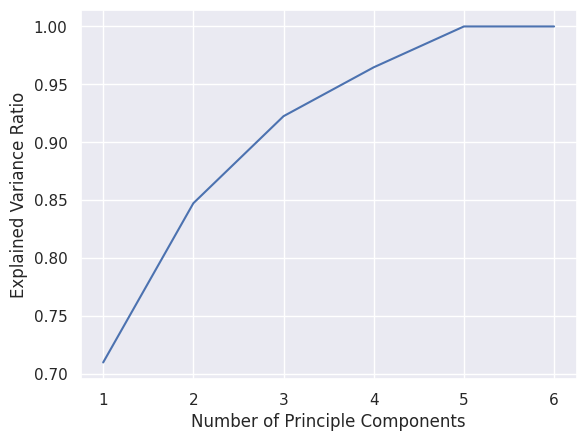

In [138]:
''' [10 points]
Plot the cumulative explained variance as a function of number of principal components
The plot should have `seaborn` style
The plot should have correct axis labels, xticks/labels (1,2,3,4,5,6 number of PCs) precisely as the plot below
'''
#----- Find cumulative sum of explained variance ratio for each PC -----#
pca_2 = PCA()
X3D_2 = pca_2.fit_transform(X)
explained_var_ratio = pca_2.explained_variance_ratio_

ratios = np.cumsum(explained_var_ratio)
num_PCs = [1, 2, 3, 4, 5, 6]

#------Graphing------#
sns.set_theme()

x_label = 'Number of Principle Components'
y_label = 'Explained Variance Ratio'
x_axis = num_PCs
y_axis = ratios

chart = sns.lineplot(x = x_axis, y = y_axis)
chart.set_xlabel(x_label)
chart.set_ylabel(y_label)

In [139]:
print('Feature Importances')
print(important_features)

Feature Importances
[0.14806926 0.09190964 0.1370306  0.13711971 0.1003241  0.38554669]


In [140]:
pc_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
PC-1,0.323646,0.113192,0.303675,0.210453,-0.029960,0.863154
PC-2,-0.476635,-0.098563,-0.532784,-0.378072,0.321809,0.482438
PC-3,-0.001545,-0.264657,-0.496542,0.263113,-0.774613,0.118941


### Part II Questions

Anwser the following question HERE:

**Q4** [4 points] - Specify for each PC, which feature has the highest correlation (absolute value of the corresponding coeffieicent) with that PC? You should name the feature that has the highest (absolute value) coefficient in the `pc_df` dataframe above - the one which has PCs as rows.

ANSWER to Q4:

PC1 highest absolute value of corresponding coefficient: 0.863154 (`degree_spondylolisthesis`)

PC2 highest absolute value of corresponding coefficient: 0.532784 (`lumbar_lordosis_angle`)

PC3 highest absolute value of corresponding coefficient: 0.774613 (`pelvic_radius`)


**Q5** [4 points] - Which of the 6 features has the highest importance in random forest `feature_importances_` which also has a high correlation (the absolute value of its corresponding coefficient) with one of the 3 PCs returned by PCA? Notice that this can be an indication of consistency between PCA results and `feature_importances_` of RF classifier.

ANSWER to Q5:

`degree_spondylolisthesis` has both the highest feature importance and highest correlation (absolute value of coefficient) with PC1. The feature importance of `degree_spondylolisthesis` is 0.38554669 and the absolute value of the coefficient for `degree_spondylolisthesis` is 0.863154. 

**Q6** [12 points]
- **(a)** [2 points] - Based on the explained variance ratio plot, what is an appropriate number for principal compoenents if the goal is to preserve at least 97% of variance?

ANSWER to Q6 (a):

Based off of a purely visual inspction of the plot, 4 principle components would preserve roughly 97% of the variance of the data. A more thorough examination should be used to be sure that 4 PCs would preserve the desired amount of variance.

- **(b)** [5 points] What is the exact value of cumulative explained variance (a float number with NO rounding) when the number of principal components is 4? The cumulative explained variance for $n$ PCs is the sum of explained variance ratio of the first $n$ PCs. To answer this part, you must code in the cell below and get the cumulative explained variance when the number of PCs is four.

In [141]:
# ANSWER to Q6 (b) - You must write code to answer the question!
ans_to_question = ratios[3]  # Original list used to plot the cumulative explained variance calculated earlier

print("Cumulative explained variance for 4 principle components: {}%".format(ans_to_question))

Cumulative explained variance for 4 principle components: 0.9646917964216533%


- **(c)** [5 points] What is the mean cv score if you reduce to the number of dimensions while preserving at least 0.96 of variance? To answer this part, you must code in the cell below, do PCA which preserves 0.96 of variance and report the mean cv score (same cv hyperparameters as before).

**Hint**: Note that instead of specifying the number of components as say 3 or 4, you can specify a float number between 0.00 to 1.00 to indicate how much of the variance should be preserved in PCA. Then, with the same hyperparameter values of RF and cv, your mean cv score should slightly increase if you do the PCA correctly while preserving 0.96 of variance.

In [142]:
# ANSWER to Q6 (c) - You must write code to answer the question!
pca_Q6C = PCA(0.96)
X_Q6C = pca_Q6C.fit_transform(X)
rf_cv_score_Q6C = cross_val_score(best_rf, X_Q6C, y, cv = 10, scoring='balanced_accuracy')

print('3D PCA Mean CV score for best_rf: {}'.format(rf_cv_score.mean()))
print('96% Variance PCA Mean CV score for best_rf: {}'.format(rf_cv_score_Q6C.mean()))

difference = rf_cv_score_Q6C.mean() - rf_cv_score.mean()
print('Difference between 96% Variance Mean CV and 3D PCA Mean CV: {}'.format(difference))

positive = difference > 0
print('Is the difference positive? --> {}'.format(positive))

if positive:
    print("The 96% PCA Mean CV score is larger than the 3D PCA Mean CV Score.")


# This is using the tuned RF model best_rf from part 1 rather than the un-tuned rf_clf model.
# As seen below, the 96% variance PCA mean CV score 
# is slightly higher than the 3D PCA in regards to their mean CV scores. 

3D PCA Mean CV score for best_rf: 0.6044444444444442
96% Variance PCA Mean CV score for best_rf: 0.6044444444444445
Difference between 96% Variance Mean CV and 3D PCA Mean CV: 2.220446049250313e-16
Is the difference positive? --> True
The 96% PCA Mean CV score is larger than the 3D PCA Mean CV Score.


# Part III - Image Segmentation with Clustering

In Part III, you're going to perform image segmentation using K-Means algorithm and Gaussian Mixture Models (GMM) by EM algorithm.

As discussed in the lectures, there are different applications for clustering. One application is image segmentation which you are going to do on a simple image as practice.

You are going to use the implementations of K-Means and GMM (EM algorithm) provided in scikit-learn. Let's see one simple example first with K-Means. The code for this example is provided for you to learn how to do it.

> Download [pic.jpeg](https://github.com/fereydoonvafaei/CMSC478-Spring-2022/blob/main/pic.jpeg) and save it in your working directory.

(192, 263, 3)


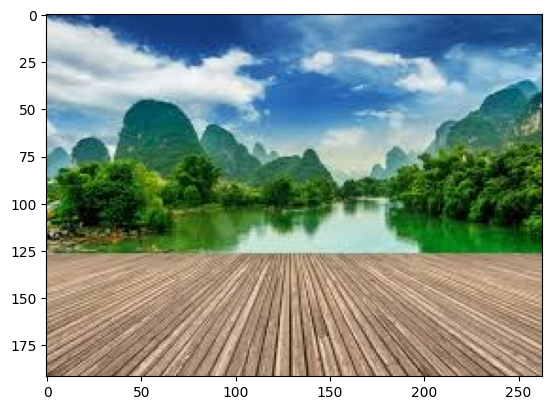

In [143]:
# Load pic - Don't forget to include matplotlib in the Import cell at the top of the notebook!
plt.style.use('default')
pic = plt.imread('pic.jpeg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic) 

In [144]:
# Reshape the pic to make it a 2D array
pic_array = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_array.shape

(50496, 3)

> Next create a kmeans model from [KMeans class in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and train it on `pic_array`.

In [145]:
# Create KMeans from sklearn with 5 clusters and fit it to pic_array (of course you have to import it first)
kmeans = KMeans(n_clusters=7, random_state=0).fit(pic_array)
pic_clusters = kmeans.cluster_centers_[kmeans.labels_]

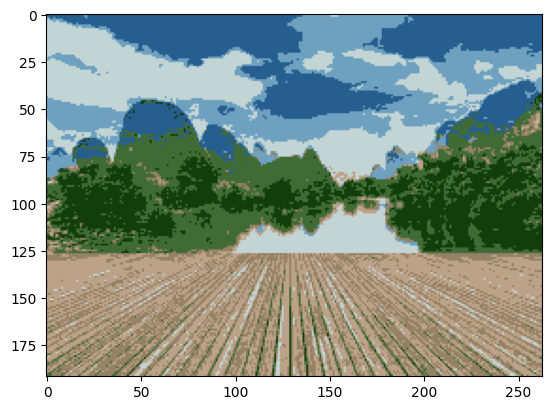

In [146]:
# Show the color segmented image
segmented_pic = pic_clusters.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(segmented_pic)

> Looks like a reasonable number of segments/clusters as you have the sky, clouds, tress, lake and the ground. Try with different number of clusters/segments and see the results.

> Now download [cat.jpeg](https://github.com/fereydoonvafaei/CMSC478-Spring-2022/blob/main/cat.jpeg) and save it in your working directory.

(300, 444, 3)


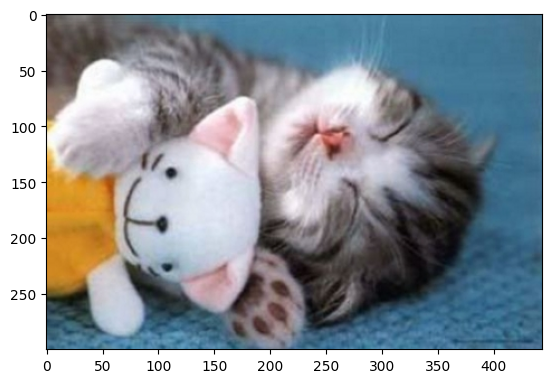

In [147]:
cat = plt.imread('cat.jpeg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(cat.shape)
plt.imshow(cat)

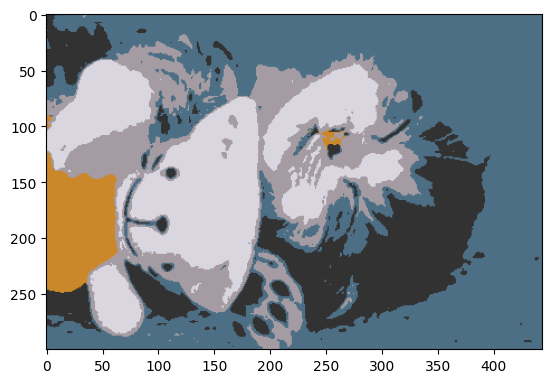

In [148]:
# Apply K-Means algorithm on the cat image with 5 clusters/segments.
# You should do the same steps as the previous image.
cat_array = cat.reshape(cat.shape[0]*cat.shape[1], cat.shape[2])
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(cat_array)
cat_clusters = kmeans2.cluster_centers_[kmeans2.labels_]
segmented_cat = cat_clusters.reshape(cat.shape[0], cat.shape[1], cat.shape[2])
plt.imshow(segmented_cat)

> Now let's use [GMM from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

In [149]:
# Create a gm model with 5 clusters and fit it to cat_array

gm = GaussianMixture(n_components=5, random_state=0).fit(cat_array)


In [150]:
# Check if gm converged
converged = gm.converged_
print(converged)

True


In [151]:
# Get gm_clusters using predict method on cat_array
gm_clusters = gm.predict(cat_array)
gm_clusters.shape

(133200,)

In [152]:
# Show gm clusters 
gm_clusters

array([3, 3, 3, ..., 1, 1, 1])

> Now there are two ways to display the segmented cat images by gm, both provided below:

(300, 444)


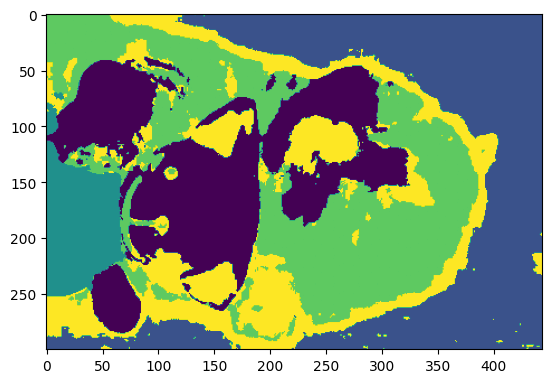

In [153]:
# 1st way to show segmented_cat_gm
segmented_cat_gm = gm_clusters.reshape(cat.shape[0], cat.shape[1])
print(segmented_cat_gm.shape)
plt.imshow(segmented_cat_gm)

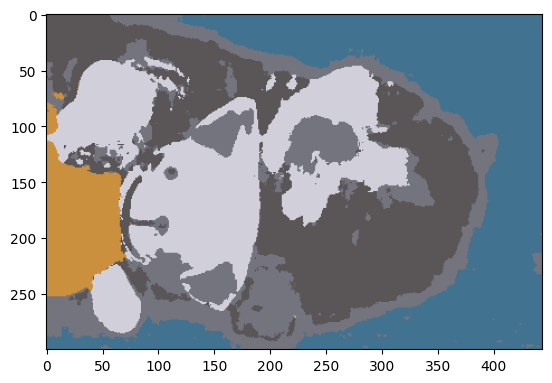

In [154]:
# 2nd way to show segmented_cat_gm
plt.imshow(gm.means_[segmented_cat_gm])

> Looks like GMM actually did a better job on segmenting the background (blue carpet) although the visuall appearance for the cat itself is not as good. You can now try with some other images of your choice and have some fun!

## Grading

Assignment-3 has a maximum of 100 points. **You must run all cells** and get the correct outputs for all cells and give complete answers to all questions. **Cells/codes with no output get zero!** Also, your notebook should be written with no grammatical and spelling errors and should be easy-to-read.

The breakdown of the 100 points is as follows:

- Part-I - 50 points - Incorrect/incomplete plot in Part-I gets zero.
    - Implementation and results: 40 points
        - Correct RF classifier: 20 points
        - Correct n_estimators plot: 20 points
    - Part-I Questions: 10 points


- Part-II - 40 points - Incorrect/incomplete plot in Part-II gets zero.
    - Implementation and results: 20 points
        - Correct PCA: 10 points
        - Correct explained variance ratio plot: 10 points
    - Part-II Questions: 20 points
  
  
- Part-III - 10 points
    - Implementation and correct segmented images: 10 points

Grading will be based on 

  * correct implementation, correct results, plots, and outputs, and correct answer to the questions, and
  * readability of the notebook.

<b>Note: </b>Follow the instructions of each section carefully. Up to 10 points may be deducted if your submitted notebook is not easy to read and follow or if it has grammatical, spelling or formatting issues.

## Submission

Name your notebook ```Lastname-A3.ipynb```. Submit the completed notebook using the ```Assignment-3``` link on Blackboard.
  
<font color=red><b>Due Date: Thursday April 14th, 11:59PM</b></font>